# Data Augmentation

#### MPA_ED@WASSA2022


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
df_ge = pd.read_csv("goemotions_3.csv") # GoEmotions Dataset 
df_ws = pd.read_csv("messages_train_ready_for_WS.tsv", sep = '\t') # WASSA Dataset
df_ws = df_ws[['emotion', 'essay']]

In [3]:
unq_emotions = list(set(df_ws['emotion'].tolist())) # List of all 7 emotions
print(unq_emotions)

['anger', 'sadness', 'fear', 'surprise', 'joy', 'disgust', 'neutral']


### Function : Removes data points labeled with multiple emotions

In [4]:
def transform_ge(df):

    new_texts = []
    new_emotion = []
    for i in range(len(df)):
        for emo in unq_emotions:
            if df[emo][i] == 1:
                new_emotion.append(emo)
                new_texts.append(df['text'][i])
    clean_df = pd.DataFrame({'text': new_texts, 'emotion': new_emotion})
    clean_df = clean_df.drop_duplicates(subset=['text'],ignore_index=True)
    return clean_df

In [5]:
clean_ge = transform_ge(df_ge)

### Function: Converts DataFrame to dictionary {emotion : [text1, text2,....]}

In [6]:
def df2dict(df, unq_emotions):
    tex_type = None
    if 'text' in df:
        tex_type = 'text'
    else:
        tex_type = 'essay'
    data_dict = dict()
    
    for emo in unq_emotions:
        data_dict[emo] = []
    
    for i in range(len(df)):
        data_dict[df['emotion'][i]].append(df[tex_type][i])
    
    return data_dict

In [7]:
ge_dict = df2dict(clean_ge, unq_emotions)
ws_dict = df2dict(df_ws, unq_emotions)

In [8]:
ws_counts = dict(df_ws['emotion'].value_counts())
ge_counts = dict(clean_ge['emotion'].value_counts())

### Function: Systematic Sampling
>Systematic sampling is a type of probability sampling method in which sample members from a larger population are selected according to a random starting point but with a fixed, periodic interval. This interval, called the sampling interval, is calculated by dividing the population size by the desired sample size.

In [9]:
def sampler(data,new_size):
    new_data = []
    ind = len(data)/(new_size+1)
    for i in range(1,new_size+1):
        #print(ind*i)
        new_data.append(data[int(ind*i)])
    return new_data

### Function: Augmented Over-UnderSampling (AOUS)
> If X denotes the number of
data points per class, in this method, if
the data points in a particular class are
greater than X, we undersample the data by
randomly removing the essays. Otherwise,
the data is oversampled by simply adding
Reddit comments with maximum lengths
from GoEmotions dataset (sorted by lengths). As the average length of comments
in GoEmotions dataset is 12 and average
length of essays in WASSA dataset is 84, the
comments with maximum length are chosen
for oversampling.

### Function: Augmented Over Sampling (AOS)
> X denotes the highest number of data points per
class. If the number of data points is less
than X, the data is oversampled by adding
comments from GoEmotions dataset with the
highest lengths.
![Image of AOS AOUS](https://docs.google.com/drawings/d/e/2PACX-1vSjuA0grkvkwVHC_70GvTGzEoSp_RTRqgNQHJO6YQFaLlZYjMbfKDUshrM2WLA8NQppUskovPy_i7nd/pub?w=1047&h=571)

In [10]:
def AOUS(req_len, ws_dict, ge_dict, ws_counts, unq_emotions):
    '''
    req_len : number of labels per class after over under sampling
    ws_dict : dictionary of WASSA Dataset {emotion : [text1, text2,....]}
    ws_counts : Label counts per class in WASSA Dataset
    ge_counts : Label counts per class in GoEmotion Dataset
    
    '''
    new_essay = []
    new_emotion = []
    
    ge_len_com = dict() # {emotion: [[lenght of comment_1, comment_1], [lenght of comment_2, comment_2]....]}
    
    for emo in unq_emotions:
        ge_len_com[emo] = []

    for emo in unq_emotions: 
        comments = ge_dict[emo]
        for comment in comments:
            ge_len_com[emo].append([len(comment.split()), comment])
        ge_len_com[emo].sort()
    
    for emo in unq_emotions:
        deficit = req_len - ws_counts[emo]
        
        if deficit <= 0: # if emotions per class are greater than required emotions
            random.shuffle(ws_dict[emo])
            new_essay += ws_dict[emo][:req_len]
            new_emotion += [emo]*req_len
            

        else: # if emotions per class are less than required emotions
            new_essay += ws_dict[emo]
            new_emotion += [emo]*len(ws_dict[emo])
            for i in range(deficit):
                new_essay.append(ge_len_com[emo][-1][-1])
                new_emotion.append(emo)
                ge_len_com[emo].pop()
                
    return pd.DataFrame({'emotion':new_emotion, 'essay':new_essay})
                    

In [11]:
aous = AOUS(400, ws_dict, ge_dict, ws_counts, unq_emotions)

In [12]:
def AOS(ws_dict, ws_counts, ge_counts, unq_emotions):
    '''
    ws_dict : dictionary of WASSA Dataset {emotion : [text1, text2,....]}
    ws_counts : Label counts per class in WASSA Dataset
    ge_counts : Label counts per class in GoEmotion Dataset
    
    '''
    req_len = max([ws_counts[k] for k in ws_counts])
    new_essay = []
    new_emotion = []
    
    ge_len_com = dict() # {emotion: [[lenght of comment_1, comment_1], [lenght of comment_2, comment_2]....]}
    
    for emo in unq_emotions:
        ge_len_com[emo] = []

    for emo in unq_emotions: 
        comments = ge_dict[emo]
        for comment in comments:
            ge_len_com[emo].append([len(comment.split()), comment])
        ge_len_com[emo].sort()
    
    for emo in unq_emotions:
        deficit = req_len - ws_counts[emo]
        new_essay += ws_dict[emo]
        new_emotion += [emo]*len(ws_dict[emo])
        for i in range(deficit):
            new_essay.append(ge_len_com[emo][-1][-1])
            new_emotion.append(emo)
            ge_len_com[emo].pop()

    return pd.DataFrame({'emotion':new_emotion, 'essay':new_essay})
                             

In [13]:
aos = AOS(ws_dict, ws_counts, ge_counts, unq_emotions)

### Function : Random synthetic oversampling
> We observe a significant difference in the average comment length of GoEmotions dataset
and the average essay length in the WASSA
dataset. To avoid disturbing the length distribution of the WASSA dataset after oversampling, we create synthetic essays by concatenating multiple random comments with same
emotion (Fig 4). We match the distribution of
lengths of the synthetically generated essays
from GoEmotions dataset with the distribution
of the original dataset using “Systematic Sampling.” We eliminate the deficit in each class
by adding synthetically generated essays.

![Image of AOS AOUS](https://docs.google.com/drawings/d/e/2PACX-1vR-tZrrX7X8MZG6tjPMVdIkwoEZGhtD98TJccDZoQ20NEa75LzHd0Kz7gZHaRaKHQm-NswSW0FS85AU/pub?w=1192&h=779)


In [14]:
def RSO(unq_emotions,df_ws,ws_counts, ge_dict):
    
    essay_new = []
    emotion_new = []
    
    essay_lengths = []
    for i in range(len(df_ws)):
        essay_lengths.append(len(df_ws['essay'][i].split()))
    essay_lengths.sort()
    
    for emo in unq_emotions:
        essay_new += ws_dict[emo]
        emotion_new += [emo]*len(ws_dict[emo])
        deficit = 647 - ws_counts[emo]
#         if deficit < 0:
#             under_samp_emo.append(emo)
#             continue
        req_lengths = sampler(essay_lengths, deficit)
        for req_len in req_lengths:
            essay = ''
            word_ctr = 0
            while word_ctr <= req_len:
                n = random.randint(0,len(ge_dict[emo])-1)
                essay += ge_dict[emo][n].strip() + ' '
                word_ctr += len(ge_dict[emo][n].split())
            essay_new.append(essay)
            emotion_new.append(emo)
    return pd.DataFrame({'emotion':emotion_new, 'essay':essay_new})

In [15]:
rso = RSO(unq_emotions,df_ws,ws_counts, ge_dict)

### Function: Plot the length distributon of a dataset

In [16]:
def plot_lengths(df, title):
    text = 'essay'
    labels = 'emotion'
    lengths = []
    for i in range(len(df)):
        lengths.append(len(df['essay'][i].split()))
    plt.hist(lengths, bins=8, edgecolor='black')
    plt.xlabel('length')
    plt.ylabel('Sentence counts')
    plt.title(title)
    plt.show()

### Length Disrtribution of orignal dataset

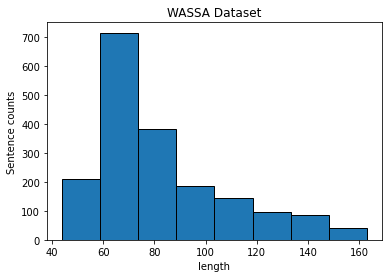

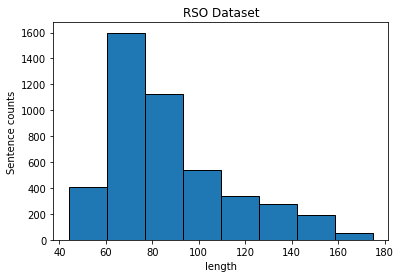

In [17]:
plot_lengths(df_ws, 'WASSA Dataset')
plot_lengths(rso, 'RSO Dataset')

In [18]:
aos.to_csv('AOS.csv', index = False)
aous.to_csv('AOUS.csv', index = False)
rso.to_csv('RSO.csv', index = False)